In [19]:
# Team 69
# Dillon Blake 1524907
# Andrea Delahaye 1424289
# Yue Peng 958289
# Jeff Phan 1577799
# Alistair Wilcox 212544

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from scipy.stats import kruskal
import requests
import json
import pickle
import plotly.express as px
import ipywidgets as widgets
from ipyleaflet import Map, Marker, Heatmap
import time

warnings.filterwarnings("ignore")

WEATHER_NUM_COL = ['UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain']
FISSION_URL = 'http://172.26.135.52:9090/'
FISSION_HEADERS = {'HOST': 'fission'}

scaler = MinMaxScaler()

In [2]:
def get_full_data(params):
    # Define search query (optional, can be empty to retrieve all documents)
    data = []
    max_retries = 3
    retry_delay = 5  # seconds
    timeout = 60  # seconds

    for _ in range(max_retries):
        try:
            res = requests.get(f"{FISSION_URL}/{params}", headers=FISSION_HEADERS, timeout=timeout)
            if res.status_code != 200:
                return None
            data = json.loads(res.text)
            return data
        except requests.exceptions.RequestException as e:
            print(f"Connection error: {e}")
            print("Retrying in 5 seconds...")
            time.sleep(retry_delay)
    
    print("Max retries exceeded. Unable to retrieve data.")
    return None


def clean_data(crashes_df):
    crashes_df_copy =  crashes_df.copy(deep=True)
    # drop unnecessary columns
    crashes_df_copy = crashes_df_copy.drop(columns=['_index', '_id', '_score'])
    # rename columns _source.light_condition to light_condition, _source.crash_date to crash_date, _source.severity to severity
    crashes_df_copy = crashes_df_copy.rename(columns={"_source.light_condition": "light_condition", "_source.crash_date": "crash_date", "_source.severity": "severity","_source.location": "location"})
    #convert crash_date to datetime DD/MM/YYYY
    crashes_df_copy['crash_date'] = pd.to_datetime(crashes_df_copy['crash_date']).dt.strftime('%d/%m/%Y')
    #drop rows with missing/magic values (severity == -1)
    crashes_df_copy = crashes_df_copy[crashes_df_copy['severity'] != -1]
    #convert location array to 2 columns
    crashes_df_copy = pd.concat([crashes_df_copy, crashes_df_copy['location'].apply(pd.Series)], axis=1)
    # rename columns 0 to Latitude, 1 to Longitude
    crashes_df_copy = crashes_df_copy.rename(columns={0: "longitude", 1: "latitude"})
    crashes_df_copy['severity'] = crashes_df_copy['severity'].astype(int)
    crashes_df_copy['Station ID'] = crashes_df_copy['Station ID'].astype(str)
    crashes_df_copy['severity_normalized'] = scaler.fit_transform(crashes_df_copy[['severity']])
    return crashes_df_copy


def plot_trend(crashes_df_copy2):
    # Convert the crash_date to datetime format
    crashes_df_copy2['crash_date'] = pd.to_datetime(crashes_df_copy2['crash_date'], format='%d/%m/%Y')

    # Extract year and month from the crash_date
    crashes_df_copy2['year'] = crashes_df_copy2['crash_date'].dt.year
    crashes_df_copy2['month'] = crashes_df_copy2['crash_date'].dt.month

    # Group by year and month and count the number of crashes
    monthly_crashes = crashes_df_copy2.groupby(['month']).size().reset_index(name='crash_count')

    # Create a date column for plotting
    # monthly_crashes['date'] = pd.to_datetime(monthly_crashes[['month']].assign(day=1))

    
    # Plot the trend line
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=monthly_crashes, x='month', y='crash_count', marker='o')
    plt.title('Monthly Trend of Crash Counts per Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Crashes')
    plt.grid(True)
    plt.show()

def update_plot(plot_output, df):
    with plot_output:
        #remove all current plot
        plt.clf()
        # Convert the crash_date to datetime format
        df['crash_date'] = pd.to_datetime(df['crash_date'], format='%d/%m/%Y')

        # Extract year and month from the crash_date
        df['year'] = df['crash_date'].dt.year
        df['month'] = df['crash_date'].dt.month

        # Group by year and month and count the number of crashes
        monthly_crashes = df.groupby(['month']).size().reset_index(name='crash_count')

        plot_output.clear_output()  # Clear the previous plot
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=monthly_crashes, x='month', y='crash_count', marker='o')
        plt.xlabel('Date')
        plt.ylabel('Value')
        # plt.grid(True)
        plt.show()


def get_closest_station(lat, lon):
    resp = requests.get(URL+f'stations/{lon}/{lat}').json()
    return resp['Data']['Station ID'], resp['Data']['location']

# Define a function to update the circle location based on the marker location
def update_location(change, plot_output):
    # Summary of the study
    LOCATION = change['new']
    RADIUS = slider.value
    SIZE = 1000
    resp = requests.get(URL+f'stations/{LOCATION[1]}/{LOCATION[0]}').json()
    STATION_ID = resp['Data']['Station ID']
    STATION_LOCATION = resp['Data']['location']
    params = f"crashes/{STATION_ID}/{SIZE}/{RADIUS}"
    resp = get_full_data(params)
    dfs = []
    if resp is None or "Data" not in resp or "Token" not in resp or "Status" not in resp:
        print("Server error - unable to make a request for crash data")
    elif resp["Data"] == [] or resp["Token"] == "END" or resp["Status"] != 200:
        print("Error fetching data - no data available")
    else:
        while resp and "Token" in resp and resp["Token"] != "END":
            temp = pd.json_normalize(resp["Data"])
            temp['Station ID'] = STATION_ID
            dfs.append(temp)
            params = f"stream/{resp['Token']}"
            resp = get_full_data(params)
    if dfs == []:
        print("No data available")
    else:
        crashes_df_tmp = pd.concat(dfs, ignore_index=True)
        crashes_df2 = clean_data(crashes_df_tmp)
        # Create a list of locations with severity
        heatmap_data = crashes_df2[['latitude', 'longitude', 'severity_normalized']].values.tolist()
        crashes_df = crashes_df2
        heatmap.locations = heatmap_data
        update_plot(plot_output, crashes_df)

# Function to get min and max crash dates for a given station ID
def get_min_max_dates(station_id):
    # Filter DataFrame for the given station ID
    station_data = crashes_per_day[crashes_per_day['Station ID'] == station_id]
    
    # Find minimum and maximum crash dates
    min_date = station_data['crash_date'].min().year
    max_date = station_data['crash_date'].max().year
    
    return min_date, max_date

# Retrieve Weather Stations

In [3]:

resp = get_full_data('stations')
if resp is None:
    print("Failed to retrieve data.")
elif resp['Status'] != 200:
    print(f"Failed to retrieve data. Status code: {resp['Status']}")
stations = pd.DataFrame(resp["Data"])

# # drop unnecessary columns
stations = stations.drop(columns=['created_at'])
stations_copy = stations.copy(deep=True)
stations.head()

,Station ID,Station Name,location
0,3003,BROOME AIRPORT,"[122.2352, -17.9475]"
1,9965,BUNBURY,"[115.6447, -33.3567]"
2,39128,BUNDABERG AERO,"[152.323, -24.9069]"
3,23000,ADELAIDE (WEST TERRACE / NGAYIRDAPIRA),"[138.5832, -34.9257]"
4,87184,BREAKWATER (GEELONG RACECOURSE),"[144.3765, -38.1737]"


# Retrieve crashes for each weather station

In [4]:
#loop through all stations
size = 3000 #number of crashes to get
radius = 10 #radius in kms
crashes = {}
empty_stations = []
error_stations = []
dfs = []
for index, station in stations_copy.iterrows():
    station_id = station['Station ID']
    crashes[station_id] = crashes.get(station_id, [])
    params = f"crashes/{station_id}/{size}/{radius}"
    resp = get_full_data(params)
    if resp is None or "Data" not in resp or "Token" not in resp or "Status" not in resp:
        error_stations.append(station_id)
        continue
    elif resp["Data"] == [] or resp["Token"] == "END" or resp["Status"] != 200:
        empty_stations.append(station_id)
        continue
    else:
        while resp and "Token" in resp and resp["Token"] != "END":
            temp = pd.json_normalize(resp["Data"])
            temp['Station ID'] = station_id
            dfs.append(temp)
            params = f"stream/{resp['Token']}"
            resp = get_full_data(params)

crashes_df = pd.concat(dfs, ignore_index=True)
crashes_df

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>

,_index,_id,_score,_source.light_condition,_source.crash_date,_source.severity,_source.location,Station ID
0,crashes,uXZkcI8B_XhVKXBOdiHt,1.0,Daylight,2014-06-06T00:00:00.000+0000,0,"[147.44585073, -42.8383444766]",94250
1,crashes,6XZkcI8B_XhVKXBOdiHt,1.0,Darkness (with street light),2014-06-09T00:00:00.000+0000,1,"[147.561045969, -42.7909979075]",94250
2,crashes,CXZkcI8B_XhVKXBOdiLt,1.0,Daylight,2014-06-10T00:00:00.000+0000,2,"[147.477214422, -42.8451352192]",94250
3,crashes,CnZkcI8B_XhVKXBOdiLt,1.0,Daylight,2014-05-21T00:00:00.000+0000,0,"[147.4282824, -42.8402632121]",94250
4,crashes,FHZkcI8B_XhVKXBOdiLt,1.0,Darkness (with street light),2014-06-11T00:00:00.000+0000,0,"[147.492785352, -42.8302244413]",94250
...,...,...,...,...,...,...,...,...
74077,crashes,NYZqcI8Bpkx8JL9BAzsb,1.0,Daylight,2018-01-30T00:00:00.000+0000,0,"[143.863677228, -39.9302203318]",98017
74078,crashes,OIZqcI8Bpkx8JL9BmVcr,1.0,Darkness (without street light),2019-02-16T00:00:00.000+0000,0,"[143.93109494, -39.8989643053]",98017
74079,crashes,AYZqcI8Bpkx8JL9BZ00Z,1.0,Daylight,2018-09-27T00:00:00.000+0000,0,"[143.853745471, -39.9304860372]",98017
74080,crashes,nIZqcI8Bpkx8JL9Bsl1K,1.0,Darkness (without street light),2019-05-12T00:00:00.000+0000,1,"[143.880085381, -39.8799545379]",98017


# Clean up the data

In [5]:
crashes_df_copy =  crashes_df.copy(deep=True)
# drop unnecessary columns
crashes_df_copy = crashes_df_copy.drop(columns=['_index', '_id', '_score'])
# rename columns _source.light_condition to light_condition, _source.crash_date to crash_date, _source.severity to severity
crashes_df_copy = crashes_df_copy.rename(columns={"_source.light_condition": "light_condition", "_source.crash_date": "crash_date", "_source.severity": "severity","_source.location": "location"})
#convert crash_date to datetime DD/MM/YYYY
crashes_df_copy['crash_date'] = pd.to_datetime(crashes_df_copy['crash_date']).dt.strftime('%d/%m/%Y')
#drop rows with missing/magic values (severity == -1)
crashes_df_copy = crashes_df_copy[crashes_df_copy['severity'] != -1]
#convert location array to 2 columns
crashes_df_copy = pd.concat([crashes_df_copy, crashes_df_copy['location'].apply(pd.Series)], axis=1)
# rename columns 0 to Latitude, 1 to Longitude
crashes_df_copy = crashes_df_copy.rename(columns={0: "longitude", 1: "latitude"})
crashes_df_copy['severity'] = crashes_df_copy['severity'].astype(int)
crashes_df_copy['Station ID'] = crashes_df_copy['Station ID'].astype(str)
crashes_df_copy


,light_condition,crash_date,severity,location,Station ID,longitude,latitude
0,Daylight,06/06/2014,0,"[147.44585073, -42.8383444766]",94250,147.445851,-42.838344
1,Darkness (with street light),09/06/2014,1,"[147.561045969, -42.7909979075]",94250,147.561046,-42.790998
2,Daylight,10/06/2014,2,"[147.477214422, -42.8451352192]",94250,147.477214,-42.845135
3,Daylight,21/05/2014,0,"[147.4282824, -42.8402632121]",94250,147.428282,-42.840263
4,Darkness (with street light),11/06/2014,0,"[147.492785352, -42.8302244413]",94250,147.492785,-42.830224
...,...,...,...,...,...,...,...
74077,Daylight,30/01/2018,0,"[143.863677228, -39.9302203318]",98017,143.863677,-39.930220
74078,Darkness (without street light),16/02/2019,0,"[143.93109494, -39.8989643053]",98017,143.931095,-39.898964
74079,Daylight,27/09/2018,0,"[143.853745471, -39.9304860372]",98017,143.853745,-39.930486
74080,Darkness (without street light),12/05/2019,1,"[143.880085381, -39.8799545379]",98017,143.880085,-39.879955


# Retrieve weather data for each weather station

In [6]:
crashes_per_day = crashes_df_copy.groupby(['crash_date',"Station ID"]).size()
crashes_per_day = crashes_per_day.reset_index(name='count')
crashes_per_day['crash_date'] = pd.to_datetime(crashes_per_day['crash_date'], dayfirst=True)
#getting weather data from API
weather_data = []
for station in crashes_per_day['Station ID'].unique():
    min_date, max_date = get_min_max_dates(station)
    params = f"weather/{station}/{min_date}/{max_date}"
    resp = get_full_data(params)
    if resp is None or "Data" not in resp or "Status" not in resp:
        error_stations.append(station)
        continue
    elif resp["Data"] == [] or resp["Status"] != 200:
        empty_stations.append(station)
        continue
    else:
        temp = pd.json_normalize(resp["Data"])
        temp['Station ID'] = station
        weather_data.append(temp)


weather_df = pd.concat(weather_data, ignore_index=True)
weather_df

,UV,Max Humid,created_at,Min Temp,WindSpeed,Min Humid,source,Station Name,Date,Rain,Pan-Rain,Max Temp,state,Evapo-Rain,Station ID
0,-1.0,94,2024-05-17T01:41:49.556348372Z,17.9,7.07,48,devonport_airport,DEVONPORT AIRPORT,01/01/2010,0.0,-1.0,24.3,tas,-1.0,91126
1,-1.0,100,2024-05-17T01:41:49.556353782Z,13.7,8.93,56,devonport_airport,DEVONPORT AIRPORT,02/01/2010,0.0,-1.0,23.0,tas,-1.0,91126
2,-1.0,100,2024-05-17T01:41:49.556359883Z,10.9,7.01,97,devonport_airport,DEVONPORT AIRPORT,03/01/2010,0.0,-1.0,21.8,tas,-1.0,91126
3,-1.0,100,2024-05-17T01:41:49.556365353Z,7.2,6.77,98,devonport_airport,DEVONPORT AIRPORT,04/01/2010,0.0,-1.0,20.1,tas,-1.0,91126
4,-1.0,100,2024-05-17T01:41:49.556371324Z,12.1,6.83,98,devonport_airport,DEVONPORT AIRPORT,05/01/2010,0.0,-1.0,23.7,tas,-1.0,91126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60419,16.90,92,2024-05-17T01:39:25.849342452Z,14.9,7.85,67,cape_grim,CAPE GRIM,23/12/2017,0.0,-1.0,19.9,tas,3.4,91331
60420,27.12,75,2024-05-17T01:39:25.849349706Z,12.7,11.08,49,cape_grim,CAPE GRIM,24/12/2017,0.8,-1.0,16.5,tas,5.1,91331
60421,29.84,84,2024-05-17T01:39:25.849356007Z,12.8,8.24,62,cape_grim,CAPE GRIM,25/12/2017,0.0,-1.0,18.0,tas,4.6,91331
60422,30.84,88,2024-05-17T01:39:25.849362269Z,10.4,8.25,54,cape_grim,CAPE GRIM,26/12/2017,0.0,-1.0,21.9,tas,5.4,91331


# Clean up the weather data

In [7]:
weather_df_copy = weather_df.copy(deep=True)
#drop created_at, source, Station Name columns
weather_df_copy = weather_df_copy.drop(['created_at', 'source', 'Station Name', 'Pan-Rain'], axis=1)
#add dtypes for columns
weather_df_copy['Date'] = pd.to_datetime(weather_df_copy['Date'], format='%d/%m/%Y')
weather_df_copy['Evapo-Rain'] = weather_df_copy['Evapo-Rain'].astype(float)
weather_df_copy['Rain'] = weather_df_copy['Rain'].astype(float)
weather_df_copy['Max Temp'] = weather_df_copy['Max Temp'].astype(float)
weather_df_copy['Min Temp'] = weather_df_copy['Min Temp'].astype(float)
weather_df_copy['Max Humid'] = weather_df_copy['Max Humid'].astype(int)
weather_df_copy['Min Humid'] = weather_df_copy['Min Humid'].astype(int)
weather_df_copy['WindSpeed'] = weather_df_copy['WindSpeed'].astype(float)
weather_df_copy['UV'] = weather_df_copy['UV'].astype(float)
weather_df_copy['Station ID'] = weather_df_copy['Station ID'].astype(str)
#drop rows with missing/magic values
#drop Min Temp, Max Temp	= -999
weather_df_copy = weather_df_copy[weather_df_copy['Min Temp'] != -999.0]
weather_df_copy = weather_df_copy[weather_df_copy['Max Temp'] != -999.0]
#drop Rain, Evapo-Rain, Max Humid, Min Humid = -1.0
weather_df_copy = weather_df_copy[weather_df_copy['Rain'] != -1.0]
weather_df_copy = weather_df_copy[weather_df_copy['Evapo-Rain'] != -1.0]
weather_df_copy = weather_df_copy[weather_df_copy['Max Humid'] != -1.0]
weather_df_copy = weather_df_copy[weather_df_copy['Min Humid'] != -1.0]
weather_df_copy


,UV,Max Humid,Min Temp,WindSpeed,Min Humid,Date,Rain,Max Temp,state,Evapo-Rain,Station ID
320,23.18,91,9.2,8.68,66,2010-11-17,0.0,16.5,tas,3.4,91126
321,30.44,92,13.0,8.24,28,2010-11-18,0.0,17.8,tas,5.6,91126
322,32.36,93,3.3,3.96,42,2010-11-19,0.0,15.3,tas,4.3,91126
323,32.59,95,6.5,4.55,39,2010-11-20,0.0,20.0,tas,5.2,91126
324,32.49,87,9.4,4.61,55,2010-11-21,0.0,17.8,tas,4.7,91126
...,...,...,...,...,...,...,...,...,...,...,...
60419,16.90,92,14.9,7.85,67,2017-12-23,0.0,19.9,tas,3.4,91331
60420,27.12,75,12.7,11.08,49,2017-12-24,0.8,16.5,tas,5.1,91331
60421,29.84,84,12.8,8.24,62,2017-12-25,0.0,18.0,tas,4.6,91331
60422,30.84,88,10.4,8.25,54,2017-12-26,0.0,21.9,tas,5.4,91331


In [8]:

crashes_df_copy2 = crashes_df_copy.copy(deep=True)
crashes_df_copy2['severity'] = crashes_df_copy2['severity']+1
severity_counts = crashes_df_copy2['severity'].value_counts().reset_index()
severity_counts.columns = ['Severity', 'Count']
severity_counts['Percentage'] = severity_counts['Count'] / severity_counts['Count'].sum() * 100

crashes_df_copy3 = crashes_df_copy.copy(deep=True)
# Convert 'crash_date' column to datetime in crashes_df_copy if not done already
crashes_df_copy3['crash_date'] = pd.to_datetime(crashes_df_copy3['crash_date'], dayfirst=True)
# Convert 'Date' column to datetime in weather_df_copy
weather_df_copy['Date'] = pd.to_datetime(weather_df_copy['Date'], dayfirst=True)

## Merge the weather data with the crash data for Analysis Process

In [9]:
merged_df = crashes_per_day.merge(weather_df_copy, left_on=['Station ID', 'crash_date'], right_on=['Station ID', 'Date'], how='inner')
#drop Date and crash_date columns
merged_df = merged_df.drop(['Date', 'crash_date','Station ID'], axis=1)
merged_df

,count,UV,Max Humid,Min Temp,WindSpeed,Min Humid,Rain,Max Temp,state,Evapo-Rain
0,2,33.91,86,19.2,4.78,31,0.0,29.7,tas,8.0
1,1,34.13,96,14.9,4.59,33,0.0,25.5,tas,6.8
2,3,32.19,87,13.3,6.70,22,0.0,24.1,tas,7.3
3,1,31.15,90,12.7,5.22,19,0.0,24.3,tas,6.9
4,3,31.61,92,14.5,2.61,49,0.0,27.9,tas,6.0
...,...,...,...,...,...,...,...,...,...,...
13551,1,29.15,82,15.8,4.39,50,0.0,23.9,tas,5.7
13552,1,31.06,94,14.8,3.28,28,6.4,24.8,tas,6.2
13553,6,27.39,81,13.2,6.08,26,3.4,23.4,tas,6.6
13554,5,27.94,94,2.3,11.17,54,5.6,10.7,tas,3.3


In [10]:
# Define custom colors
custom_colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51', '#6b705c']
fig = px.pie(severity_counts, names='Severity', values='Count', title='Percentage of Severity in Crash Data',
             labels={'Severity': 'Severity Level', 'Count': 'Number of Crashes'}, 
             hover_data=['Percentage'], 
             color_discrete_sequence=custom_colors,
             hole=0.3)  # hole=0.3 creates a donut chart
fig.update_layout(
    width=800,  # set the width to 800 pixels
    height=800,  # set the height to 800 pixels
    title_font_size=24,  # increase title font size
    legend_font_size=16,  # increase legend font size
    legend_title_font_size=18,  # increase legend title font size
    font=dict(
        size=18  # increase font size for labels and hover data
    )
)

# Show the pie chart
fig.show()

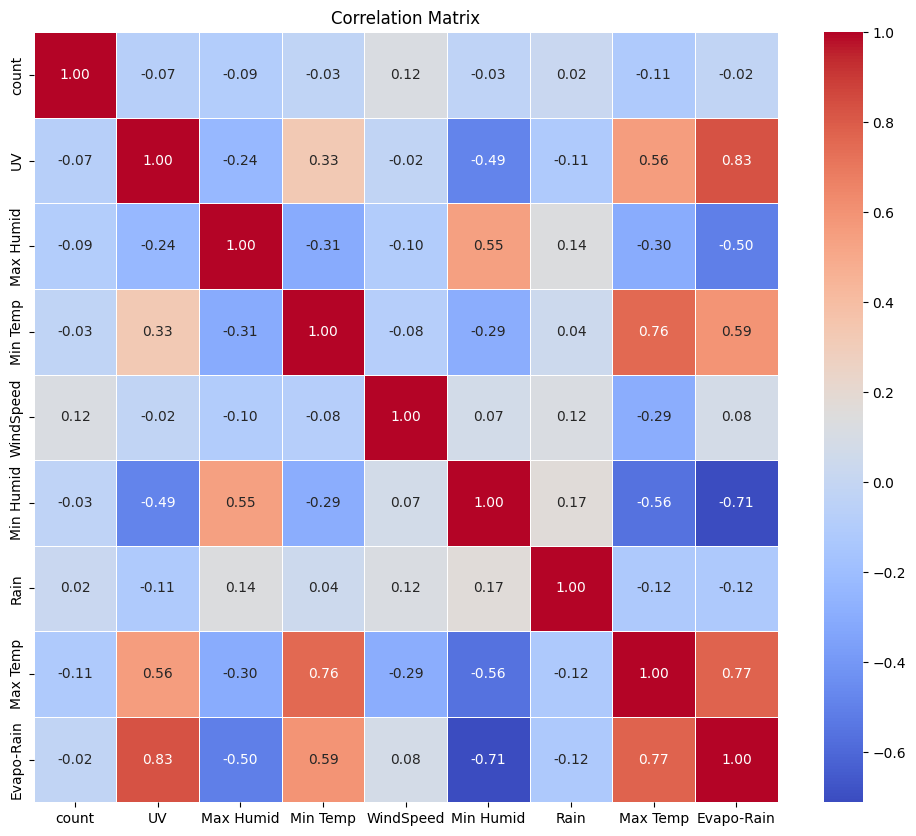

In [11]:
# Select only the numerical columns
numerical_columns = merged_df.select_dtypes(include=[np.number])
# Calculate the correlation between 'count' and the numerical columns
corr_table_pers = numerical_columns.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(corr_table_pers, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [12]:

predictor = 'WindSpeed'  # 'UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain'
r, p_value = pearsonr(numerical_columns[predictor], numerical_columns['count'])
print(f'With a correlation of {r}, the p-value associated to H0:"There is no correlation" is {p_value}')

With a correlation of 0.11838657416979272, the p-value associated to H0:"There is no correlation" is 1.6531436052360867e-43


In [13]:
predictor = 'Max Temp'  # 'UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain'
r, p_value = pearsonr(numerical_columns[predictor], numerical_columns['count'])
print(f'With a correlation of {r}, the p-value associated to H0:"There is no correlation" is {p_value}')

With a correlation of -0.11099946525421059, the p-value associated to H0:"There is no correlation" is 1.9943961543601192e-38


In [14]:
# Merge the two DataFrames on 'Station ID' and 'crash_date'
merged_df2 = crashes_df_copy3.merge(weather_df_copy, left_on=['Station ID', 'crash_date'], right_on=['Station ID', 'Date'], how='inner')
#drop Date and crash_date columns
merged_df2 = merged_df2.drop(['Date', 'crash_date','Station ID', 'location', 'longitude', 'latitude', 'light_condition', 'state'], axis=1)
#rename columns
merged_df2 = merged_df2.rename(columns={"Max Temp": "MaxTemp", "Min Temp": "MinTemp", "Max Humid": "MaxHumid", "Min Humid": "MinHumid", "Evapo-Rain": "EvapoRain"})
merged_df2

,severity,UV,MaxHumid,MinTemp,WindSpeed,MinHumid,Rain,MaxTemp,EvapoRain
0,0,6.06,92,3.5,3.47,55,0.0,14.7,1.2
1,0,6.06,92,3.5,3.47,55,0.0,14.7,1.2
2,1,6.05,94,0.5,2.93,62,0.0,9.8,0.7
3,0,6.05,94,0.5,2.93,62,0.0,9.8,0.7
4,2,6.05,94,0.5,2.93,62,0.0,9.8,0.7
...,...,...,...,...,...,...,...,...,...
46145,3,24.76,99,15.2,4.41,63,0.2,23.4,4.5
46146,0,22.16,94,13.4,2.96,60,0.0,20.3,3.7
46147,0,14.84,97,8.6,6.85,58,0.0,16.3,2.7
46148,1,7.20,98,12.8,7.04,79,0.8,15.8,1.2


In [15]:
X = merged_df[['UV', 'WindSpeed']]
y = merged_df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'XGBRegressor': XGBRegressor(),
    'CatBoostRegressor': CatBoostRegressor()
    
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{name} MSE: {mse}')
    r2 = r2_score(y_test, y_pred)
    print(f'{name} R2: {r2}\n')



Linear Regression MSE: 7.698019726745248
Linear Regression R2: 0.021664926308177845

Ridge Regression MSE: 7.69802002098057
Ridge Regression R2: 0.02166488891404983

Lasso Regression MSE: 7.841300064791441
Lasso Regression R2: 0.0034555445376951432

Decision Tree MSE: 15.444184902876813
Decision Tree R2: -0.9627889134358589

Random Forest MSE: 8.97187467854843
Random Forest R2: -0.14022826471797467

GradientBoostingRegressor MSE: 7.6811412153615
GradientBoostingRegressor R2: 0.023810002608912306

AdaBoostRegressor MSE: 11.784054724747268
AdaBoostRegressor R2: -0.49762594235368174

XGBRegressor MSE: 8.444016464877574
XGBRegressor R2: -0.07314319314089057

Learning rate set to 0.058423
0:	learn: 2.8137309	total: 59.8ms	remaining: 59.7s
1:	learn: 2.8102997	total: 60.9ms	remaining: 30.4s
2:	learn: 2.8079391	total: 62.1ms	remaining: 20.7s
3:	learn: 2.8051950	total: 63.2ms	remaining: 15.7s
4:	learn: 2.8026642	total: 64.4ms	remaining: 12.8s
5:	learn: 2.8003288	total: 65.6ms	remaining: 10.9s
6

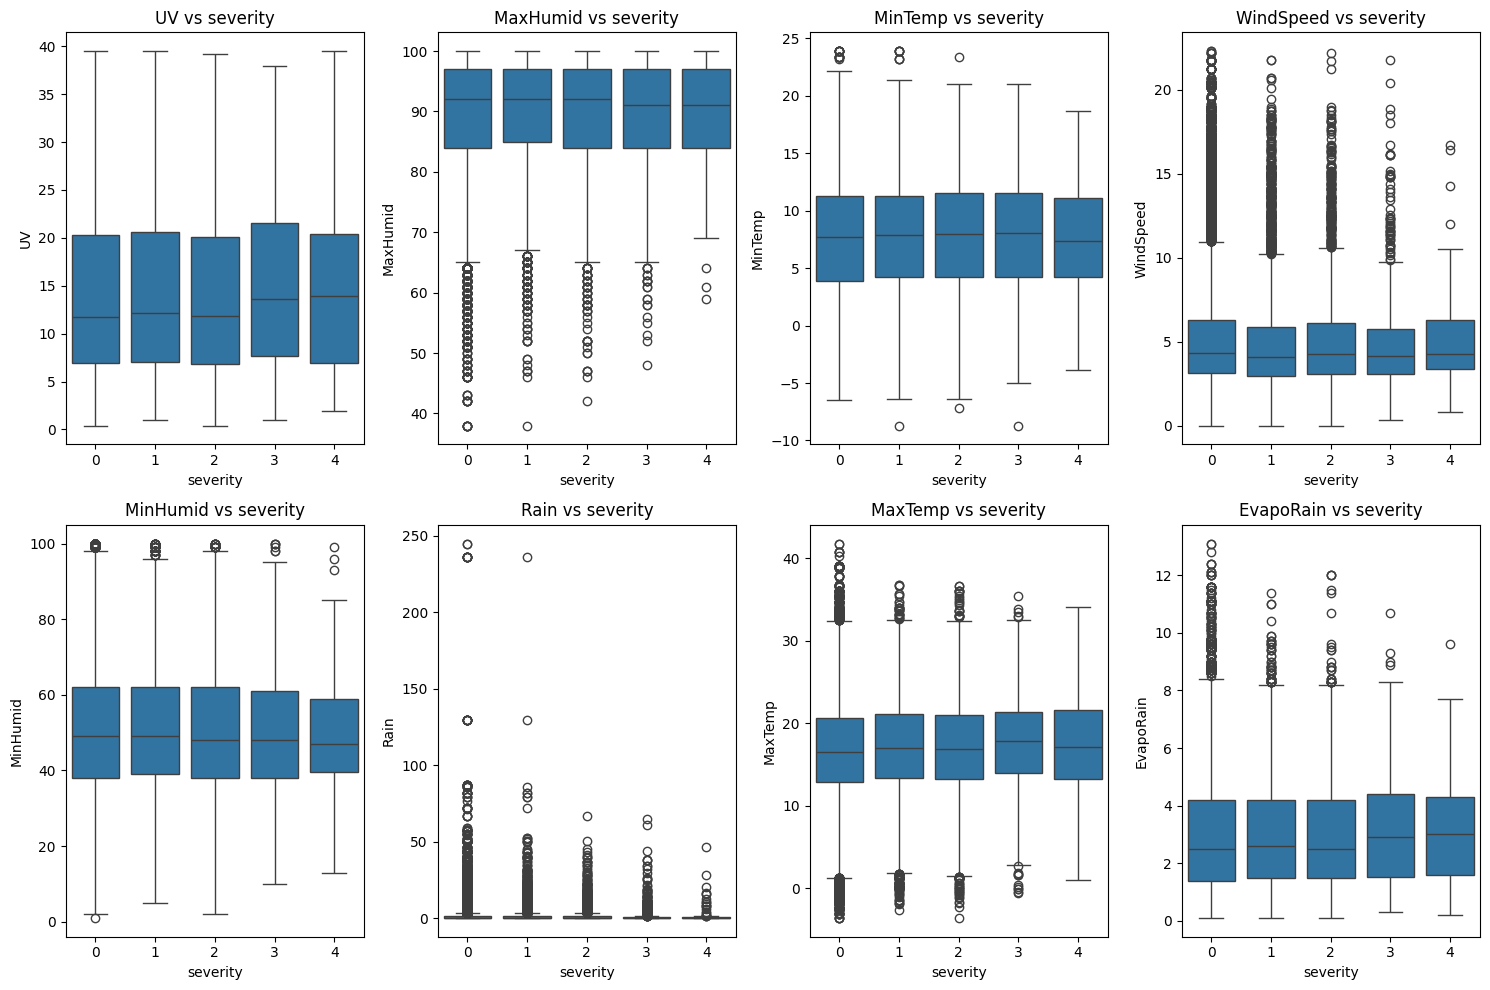

Kruskal-Wallis H test result for UV:
 KruskalResult(statistic=26.88752715882841, pvalue=2.0947299035746948e-05) 

Kruskal-Wallis H test result for MaxHumid:
 KruskalResult(statistic=3.265696180962305, pvalue=0.5143856998608749) 

Kruskal-Wallis H test result for MinTemp:
 KruskalResult(statistic=15.720430456809073, pvalue=0.003418189780664625) 

Kruskal-Wallis H test result for WindSpeed:
 KruskalResult(statistic=62.00945278408013, pvalue=1.09656033838963e-12) 

Kruskal-Wallis H test result for MinHumid:
 KruskalResult(statistic=7.955504163301394, pvalue=0.09322179974971344) 

Kruskal-Wallis H test result for Rain:
 KruskalResult(statistic=19.92704793376483, pvalue=0.0005162341030858743) 

Kruskal-Wallis H test result for MaxTemp:
 KruskalResult(statistic=66.98425273288818, pvalue=9.823682108324774e-14) 

Kruskal-Wallis H test result for EvapoRain:
 KruskalResult(statistic=16.28327547457715, pvalue=0.002661678914673658) 



In [16]:
# Select only the numerical columns ( all columns except 'severity')
numerical_columns = [col for col in merged_df2.columns if col != 'severity']
# Calculate the number of rows and columns for the subplot grid
n = len(numerical_columns)
ncols = 4
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*5))

for ax, col in zip(axs.flat, numerical_columns):
    sns.boxplot(x='severity', y=col, data=merged_df2, ax=ax)
    ax.set_title(f'{col} vs severity')

# Remove empty subplots
for ax in axs.flat[n:]:
    ax.remove()

plt.tight_layout()
plt.show()

# Perform Kruskal-Wallis H test for each numerical column
def kruskal_test(data, categorical_col, numerical_col):
    groups = data.groupby(categorical_col)[numerical_col].apply(list)
    return kruskal(*groups)

kruskal_results = {col: kruskal_test(merged_df2, 'severity', col) for col in numerical_columns}

# Print Kruskal-Wallis H test results
for col, result in kruskal_results.items():
    print(f'Kruskal-Wallis H test result for {col}:\n', result, '\n')

# Conclusion
### The significant weather conditions identified (UV, MinTemp, Rain, WindSpeed, MaxTemp, EvapoRain) suggest that certain environmental factors, especially those affecting road conditions and driver performance, are closely associated with crash severity. Specifically:

## Impact of Weather Conditions on Crash Severity
### High UV Levels: May indicate clearer weather and potentially higher speeds, which can lead to more severe crashes due to higher impact forces.
### Low Temperatures: Can result in icy roads, increasing the risk of skidding and losing control, leading to more severe crashes.
### High Wind Speeds: Create driving challenges and hazards, especially for larger vehicles, which can be blown off course, resulting in more severe accidents.
### High Temperatures: Affect tire performance (potentially causing blowouts) and driver fatigue, increasing the likelihood of more severe crashes.
### Rainfall: Leads to wet and slippery roads, reducing traction and increasing stopping distances, which can result in more severe accidents.
### EvapoRain (Evapotranspiration and Rain): Indicates high moisture levels, which can impair visibility and vehicle handling, leading to more severe crashes.

In [27]:

# Assuming X and y are your features and target variable
X = merged_df2[['UV', 'WindSpeed', 'MaxTemp', 'MinTemp', 'Rain', 'EvapoRain']]
y = merged_df2['severity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'K-NearestNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}')
    # Save the model as a pickle file
    with open(f'./crash_weather_{name}.pkl', 'wb') as file:
        pickle.dump(model, file)
    

LogisticRegression Accuracy: 0.79
K-NearestNeighbors Accuracy: 0.77
DecisionTree Accuracy: 0.74
RandomForest Accuracy: 0.75
